# Dataset Processing

1. Split `successful` and `unsuccessful` paths
2. For each human path, find the corresponding shortest length path from the `source` article to the `target` article
3. Generate a matched dataset where the `successful` and `unsucessful` paths both have the same `shortest path length`
4. Use this matched dataset for analysis

In [1]:
import pandas as pd
import os

parent_folder_path = '../Wikispeedia/wikispeedia_paths-and-graph/'

paths_finished_df=(pd.read_csv(os.path.join(parent_folder_path, 'paths_finished.tsv'), 
                               sep='\t', skiprows=15, header=None)
                   .rename(columns={0:"ip",
                                    1:"timestamp",
                                    2:"duration",
                                    3:"path",
                                    4:"rating"}))

paths_unfinished_df=(pd.read_csv(os.path.join(parent_folder_path, 'paths_unfinished.tsv'), 
                               sep='\t', skiprows=16, header=None)
                     .rename(columns={0:"ip",
                                      1:"timestamp",
                                      2:"duration",
                                      3:"path",
                                      4:"target",
                                      5:"type"}))

## Split `successful` and `unsuccessful` paths

Here, we will remove any paths with `back-track`, as indicated by `<` in the navigation path.

In [2]:
def remove_backtracks(df: pd.DataFrame) -> pd.Series:
    """this function take a DataFrame and returns the path series without back-tracks in the path"""
    paths = df['path']
    return paths[~paths.str.contains('<')]

successful_paths = remove_backtracks(paths_finished_df)
unsuccessful_paths = remove_backtracks(paths_unfinished_df)

## For each path, find the shortest length path from the `source` to the `target`

In [3]:
# first read the shortest path matrix
shortest_path_matrix = []

with open('../Wikispeedia/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt', 'r') as f:
    # the first 17 lines (indexed from 0) is the file description 
    for line in f.readlines()[17:]:
        shortest_path_matrix.append(line)
        
# the matrix now stores all shortest paths from all source articles
len(shortest_path_matrix)

4604

In [4]:
# next, we need a list of all the article names. The order of the articles 
# is the same as the shortest_path_matrix as per the file descriptions

articles = pd.read_csv('../Wikispeedia/wikispeedia_paths-and-graph/articles.tsv', sep='\t', skiprows=11, header=None)[0]
article_names_cleaned = []

# some articles have encoded names. Decode these
for article in articles:
    # the "%" character indicates an encoded name
    if "%" not in article:
        # store the article name
        article_names_cleaned.append(article)
    else:
        with open(os.path.join('../Wikispeedia/plaintext_articles', f'{article}.txt'), 'r') as f:
            # extract the correct name. It is always on the 3rd line of the article
            correct_name = f.readlines()[2].replace('\n', '')
            # store the article name
            article_names_cleaned.append(correct_name)

article_names_cleaned[:5]

['Áedán mac Gabráin',
 'Åland',
 'Édouard Manet',
 'Éire',
 'Óengus I of the Picts']

In [5]:
# for each human path, perform the following steps:
#      1. extract the source and target article
#      2. find the *index* in the article names list that corresponds to the source and target article
#      3. the corresponding *index* row in the shortest path matrix corresponds to the source article. 
#         from this list of numbers, use the target article *index* to find the *shortest path length*

def augment_with_shortest_path(series: pd.Series) -> pd.DataFrame:
    """
    this function takes a Series and returns a DataFrame with the following columns:
       1. path
       2. source article
       3. target article
       4. shortest path length
    """
    def clean_query_article_name(name: str) -> str:
        """this helper function takes an encoded article name and returns the cleaned name"""
        if "%" in name:
            with open(os.path.join('../Wikispeedia/plaintext_articles', f'{name}.txt'), 'r') as f:
                # extract the correct name. It is always on the 3rd line of the article
                return f.readlines()[2].replace('\n', '')    
        else:
            return name
        
    paths, source_articles, target_articles, shortest_paths = [], [], [], []
    
    for human_path in series:
        paths.append(human_path)
        
        split_path = human_path.split(';')
        
        source = clean_query_article_name(split_path[0])
        target = clean_query_article_name(split_path[-1])
        source_articles.append(source)
        target_articles.append(target)
        
        source_index = article_names_cleaned.index(source)
        target_index = article_names_cleaned.index(target)
        
        # query the shortest path matrix to get the correct vector (corresponding to the source article)
        shortest_path_vector = shortest_path_matrix[source_index]
        # now find the target article indexed integer in the vector
        shortest = shortest_path_vector[target_index]
        # it's not always possible to get to the target article. Impossible navigation is denoted by "_"
        if shortest == "_":
            shortest_paths.append("N/A")
        else:
            shortest_paths.append(int(shortest))
        
        
    # create the augmented DataFrame
    df = pd.DataFrame({
                      'path': paths,
                      'source_article': source_articles,
                      'target_article': target_articles,
                      'shortest_path': shortest_paths
                      })
    
    return df

In [6]:
successful_df = augment_with_shortest_path(series=successful_paths)
successful_df.head()

,path,source_article,target_article,shortest_path
0,14th_century;15th_century;16th_century;Pacific...,14th_century,African_slave_trade,3
1,14th_century;Europe;Africa;Atlantic_slave_trad...,14th_century,African_slave_trade,3
2,14th_century;Niger;Nigeria;British_Empire;Slav...,14th_century,African_slave_trade,3
3,14th_century;Renaissance;Ancient_Greece;Greece,14th_century,Greece,2
4,14th_century;Italy;Roman_Catholic_Church;HIV;R...,14th_century,John_F._Kennedy,3


In [7]:
unsuccessful_df = augment_with_shortest_path(series=unsuccessful_paths)
unsuccessful_df.head()

# shortest_path = 0 means the source article is the same as the target article 
# (Wikispeedia bug for game initialization?)

,path,source_article,target_article,shortest_path
0,Obi-Wan_Kenobi,Obi-Wan_Kenobi,Obi-Wan_Kenobi,0
1,Julius_Caesar,Julius_Caesar,Julius_Caesar,0
2,Malawi;Democracy;Alexander_the_Great,Malawi,Alexander_the_Great,2
3,Paraguay,Paraguay,Paraguay,0
4,Paraguay;Bolivia,Paraguay,Bolivia,1


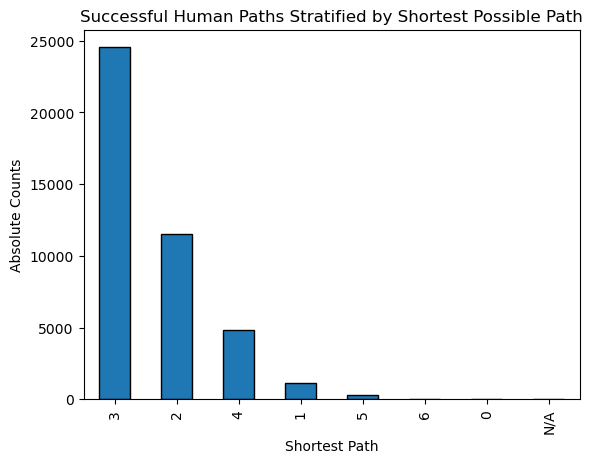

In [8]:
# take a look at the shortest_path distributions
import matplotlib.pyplot as plt

successful_counts = successful_df['shortest_path'].value_counts()
successful_counts.plot(kind='bar', edgecolor='k')
plt.ylabel('Absolute Counts'); plt.xlabel('Shortest Path');
plt.title("Successful Human Paths Stratified by Shortest Possible Path");

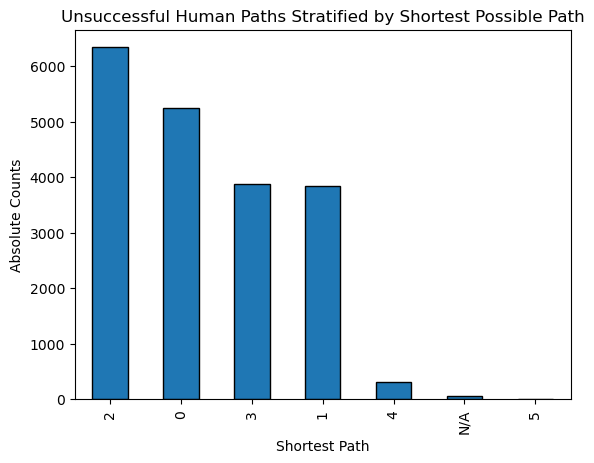

In [9]:
unsuccessful_counts = unsuccessful_df['shortest_path'].value_counts()
unsuccessful_counts.plot(kind='bar', edgecolor='k')
plt.ylabel('Absolute Counts'); plt.xlabel('Shortest Path');
plt.title("Unsuccessful Human Paths Stratified by Shortest Possible Path");